## Imports

In [1]:
pip install iterative-stratification

In [2]:
import pandas as pd
import re
from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np
from sklearn.model_selection import train_test_split
import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

In [3]:
from google.colab import userdata
#userdata.get('wandb')

In [4]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


## Data Import

The training data consists of a short text and binary labels

The data is structured as a CSV file with the following fields:
- id: a unique identifier for the sample
- text: a sentence or short text
- polarization:  1 text is polarized, 0 text is not polarized

The data is in all three subtask folders the same but only containing the labels for the specific task.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Subtask 2: Polarization Type Classification
Multi-label classification to identify the target of polarization as one of the following categories: Gender/Sexual, Political, Religious, Racial/Ethnic, or Other.
For this task we will load the data for subtask 2.

In [6]:
data = pd.read_csv('/content/drive/MyDrive/subtask3/train/eng.csv')
dev = pd.read_csv('/content/drive/MyDrive/subtask3/dev/eng.csv')

data.head()

,id,text,stereotype,vilification,dehumanization,extreme_language,lack_of_empathy,invalidation
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0,0,0,0,0,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0,0,0,0,0,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0,0,0,0,0,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0,0,0,0,0,0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0,0,0,0,0,0


In [7]:
data

,id,text,stereotype,vilification,dehumanization,extreme_language,lack_of_empathy,invalidation
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0,0,0,0,0,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0,0,0,0,0,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0,0,0,0,0,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0,0,0,0,0,0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
3217,eng_d7af338f325fcc12d4c107c591c64a19,the internalized xenophobia seething fr ppl sh...,0,0,0,0,0,0
3218,eng_8371147528d6f09acbe9b647c8fa5eb7,the radical left hates chick peas,1,0,0,0,0,0
3219,eng_4d188ccdfb84eeeaed31b7f28af538ca,this is how xenophobia and misogyny looks like,0,0,0,1,0,0
3220,eng_867cc5be4f80dafae67ab5f0f70a1ee8,yeah and committing war crimes,0,0,0,0,0,0


vilification        858
extreme_language    770
invalidation        586
stereotype          487
dehumanization      391
lack_of_empathy     357
dtype: int64
vilification        26.63
extreme_language    23.90
invalidation        18.19
stereotype          15.11
dehumanization      12.14
lack_of_empathy     11.08
dtype: float64


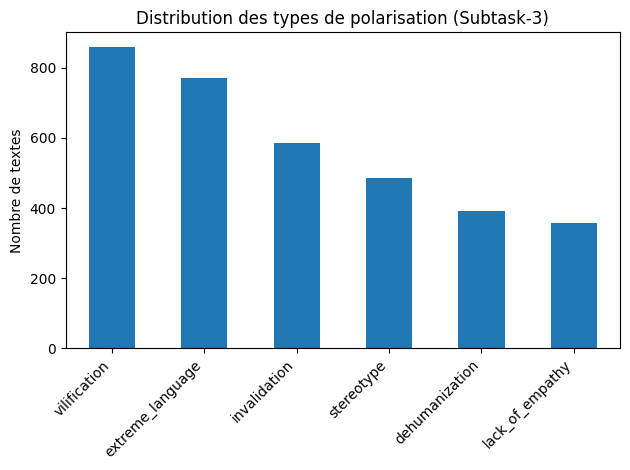

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
label_cols = ['stereotype', 'vilification', 'dehumanization', 'extreme_language', 'lack_of_empathy', 'invalidation']
label_counts = data[label_cols].sum().sort_values(ascending=False)
print(label_counts)
label_percent = (label_counts / len(data)) * 100
print(label_percent.round(2))
plt.figure()
label_counts.plot(kind="bar")
plt.title("Distribution des types de polarisation (Subtask-3)")
plt.ylabel("Nombre de textes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [10]:
data["is_polarized"] = data[label_cols].sum(axis=1) > 0

non_polarized_count = (~data["is_polarized"]).sum()
polarized_count = data["is_polarized"].sum()

print("Polarized text:", polarized_count)
print("Non-polarized text:", non_polarized_count)
print("Non-polarized percentage:", round(non_polarized_count / len(data) * 100, 2), "%")


Polarized text: 1175
Non-polarized text: 2047
Non-polarized percentage: 63.53 %


In [11]:
data["num_labels"] = data[label_cols].sum(axis=1)
data["num_labels"].value_counts().sort_index()
(data["num_labels"].value_counts(normalize=True) * 100).sort_index().round(2)
co_occurrence = pd.DataFrame(
    0, index=label_cols, columns=label_cols
)

for col1 in label_cols:
    for col2 in label_cols:
        co_occurrence.loc[col1, col2] = ((data[col1] == 1) & (data[col2] == 1)).sum()

print(co_occurrence)


                  stereotype  vilification  dehumanization  extreme_language  \
stereotype               487           379             210               321   
vilification             379           858             316               582   
dehumanization           210           316             391               262   
extreme_language         321           582             262               770   
lack_of_empathy          155           282             148               263   
invalidation             234           403             185               362   

                  lack_of_empathy  invalidation  
stereotype                    155           234  
vilification                  282           403  
dehumanization                148           185  
extreme_language              263           362  
lack_of_empathy               357           185  
invalidation                  185           586  


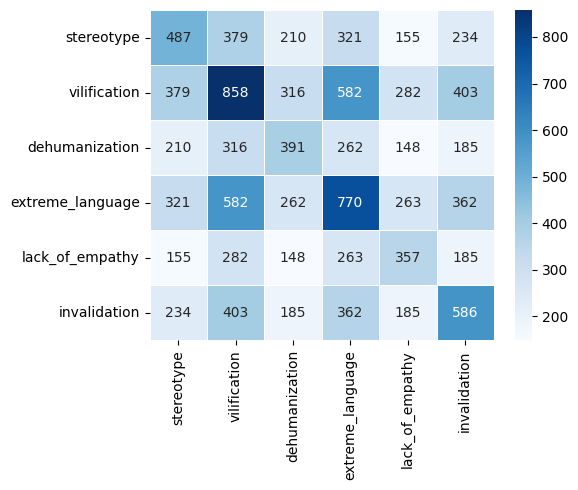

In [12]:
import seaborn as sns

co_occurrence = data[label_cols].T.dot(data[label_cols])  # co-occurrence matrix

plt.figure(figsize=(6,5))
sns.heatmap(co_occurrence, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.tight_layout()
plt.savefig("cooccurrence_eng.pdf", bbox_inches="tight")
plt.show()


In [13]:
data["text_length"] = data["text"].str.split().str.len()
data.groupby("is_polarized")["text_length"].describe()

,count,mean,std,min,25%,50%,75%,max
is_polarized,,,,,,,,
False,2047.0,11.297020,7.471137,5.0,7.0,9.0,13.0,60.0
True,1175.0,13.940426,8.645381,4.0,8.0,12.0,17.0,57.0


### Data clean

In [14]:
def clean_text(t):
    t = t.lower()
    t = re.sub(r"http\S+|www\S+", "", t)
    t = re.sub(r"[^a-z0-9.,?!' ]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t
data = data.copy()
dev = dev.copy()
data["text"] = data["text"].apply(clean_text)
dev["text"] = dev["text"].apply(clean_text)


### Slit Data

In [15]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

label_cols = ['stereotype', 'vilification', 'dehumanization', 'extreme_language', 'lack_of_empathy', 'invalidation']

X = data
y = data[label_cols].values

msss = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=0.15,
    random_state=2
)

train_idx, val_idx = next(msss.split(X, y))

train = data.iloc[train_idx].reset_index(drop=True)
val = data.iloc[val_idx].reset_index(drop=True)


# =============================================================
APPROACH 1: 3 SEPARATE MODELS

*   Model A1_1: Multi-label for ['stereotype', 'vilification', 'dehumanization']
*   Model A1_2: Binary for ['extreme_language', 'lack_of_empathy', 'invalidation']
*   Model A1_3: Binary for ["other"]

# =============================================================

In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item


In [ ]:
# ============================================================
# APPROACH 1: 3 SEPARATE MODELS
# ============================================================

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)

# ============================================================
# UTILITIES
# ============================================================

class A1_WeightedBCETrainer(Trainer):
    def __init__(self, *args, pos_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weights = pos_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = torch.nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor(self.pos_weights).to(logits.device) if self.pos_weights else None
        )
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def A1_compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    if probs.ndim == 1 or probs.shape[1] == 1:
        probs = probs.flatten()
        labels = labels.flatten()

        best_f1, best_threshold = 0, 0.5
        for threshold in np.arange(0.2, 0.8, 0.05):
            preds = (probs > threshold).astype(int)
            f1 = f1_score(labels, preds, zero_division=0)
            if f1 > best_f1:
                best_f1, best_threshold = f1, threshold

        preds_best = (probs > best_threshold).astype(int)
        return {
            'f1': best_f1,
            'precision': precision_score(labels, preds_best, zero_division=0),
            'recall': recall_score(labels, preds_best, zero_division=0),
            'threshold': best_threshold
        }
    else:
        best_f1_macro, best_threshold = 0, 0.5
        for threshold in np.arange(0.2, 0.8, 0.05):
            preds = (probs > threshold).astype(int)
            f1 = f1_score(labels, preds, average='macro', zero_division=0)
            if f1 > best_f1_macro:
                best_f1_macro, best_threshold = f1, threshold

        return {'f1_macro': best_f1_macro, 'threshold': best_threshold}

def A1_train_model(label_list, output_dir, epochs=5, lr=2e-5):
    """Train a model for given labels"""
    num_labels = len(label_list)

    # Compute pos_weights
    pos_weights = []
    print(f"\nClass weights for {output_dir}:")
    for label in label_list:
        y_train = train[label].values
        weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
        pos_weight = weights[1] / weights[0]
        pos_weights.append(pos_weight)
        n_pos = y_train.sum()
        print(f"  {label:20s}: pos_weight={pos_weight:.3f} ({n_pos}/{len(y_train)} = {n_pos/len(y_train)*100:.1f}%)")

    # Create model
    config = AutoConfig.from_pretrained(A1_model_name)
    config.num_labels = num_labels
    config.problem_type = "multi_label_classification"
    model = AutoModelForSequenceClassification.from_pretrained(A1_model_name, config=config)
    model.to(device)

    # Create datasets
    train_dataset = PolarizationDataset(
        train['text'].tolist(),
        train[label_list].values.tolist(),
        A1_tokenizer
    )
    val_dataset = PolarizationDataset(
        val['text'].tolist(),
        val[label_list].values.tolist(),
        A1_tokenizer
    )

    # Training args
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=4, # Reduced batch size
        per_device_eval_batch_size=8,  # Reduced batch size
        gradient_accumulation_steps=2, # Added gradient accumulation
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1" if num_labels == 1 else "f1_macro",
        greater_is_better=True,
        logging_steps=50,
        warmup_ratio=0.1,
        weight_decay=0.01,
        save_total_limit=2,
        seed=42,
    )

    # Train
    trainer = A1_WeightedBCETrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=A1_compute_metrics,
        data_collator=DataCollatorWithPadding(A1_tokenizer),
        pos_weights=pos_weights
    )

    print(f"\nTraining {output_dir}...")
    trainer.train()

    # Evaluate
    eval_results = trainer.evaluate()
    print(f"\nResults {output_dir}:")
    for key, value in eval_results.items():
        print(f"  {key}: {value}")

    return trainer, val_dataset

# ============================================================
# TRAIN MODELS
# ============================================================

print("="*70)
print("APPROACH 1: 3 SEPARATE MODELS")
print("="*70)

A1_model_name = 'roberta-base'
A1_tokenizer = AutoTokenizer.from_pretrained(A1_model_name)

# Model 1: Multi-label ['stereotype', 'vilification', 'dehumanization']
A1_trainer_m1, A1_val_ds_m1 = A1_train_model(
    ["stereotype", "vilification", "dehumanization"],
    './A1_results_m1',
    epochs=5,
    lr=2e-5
)

# Model 2: Multi-label ['extreme_language', 'lack_of_empathy']
A1_trainer_m2, A1_val_ds_m2 = A1_train_model(
    ["extreme_language", "lack_of_empathy"],
    './A1_results_m2',
    epochs=4,
    lr=3e-5
)

# Model 3: Binary ['invalidation']
A1_trainer_m3, A1_val_ds_m3 = A1_train_model(
    ["invalidation"],
    './A1_results_m3',
    epochs=5,
    lr=2e-5
)

# ============================================================
# COMBINE PREDICTIONS
# ============================================================

print("\n" + "="*70)
print("COMBINING 3 MODELS")
print("="*70)

# Get predictions
A1_logits_m1 = A1_trainer_m1.predict(A1_val_ds_m1).predictions
A1_labels_m1 = A1_trainer_m1.predict(A1_val_ds_m1).label_ids
A1_logits_m2 = A1_trainer_m2.predict(A1_val_ds_m2).predictions
A1_labels_m2 = A1_trainer_m2.predict(A1_val_ds_m2).label_ids
A1_logits_m3 = A1_trainer_m3.predict(A1_val_ds_m3).predictions
A1_labels_m3 = A1_trainer_m3.predict(A1_val_ds_m3).label_ids

# Reshape if needed
# Model m2 has 2 labels, so it won't be 1D. Model m3 has 1 label, so it might be 1D.
if A1_logits_m3.ndim == 1:
    A1_logits_m3 = A1_logits_m3.reshape(-1, 1)
    A1_labels_m3 = A1_labels_m3.reshape(-1, 1)

# Combine
A1_combined_logits = np.concatenate((A1_logits_m1, A1_logits_m2, A1_logits_m3), axis=1)
A1_combined_labels = np.concatenate((A1_labels_m1, A1_labels_m2, A1_labels_m3), axis=1)
A1_combined_probs = torch.sigmoid(torch.tensor(A1_combined_logits)).numpy()

print(f"Combined shape: {A1_combined_probs.shape}")

# Find optimal thresholds
A1_label_cols = ["stereotype", "vilification", "dehumanization", "extreme_language", "lack_of_empathy", "invalidation"]
A1_best_thresholds = []

print("\nOptimal thresholds:")
for i, label in enumerate(A1_label_cols):
    best_f1, best_threshold = 0, 0.5
    for threshold in np.arange(0.2, 0.8, 0.05):
        preds = (A1_combined_probs[:, i] > threshold).astype(int)
        f1 = f1_score(A1_combined_labels[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_threshold = f1, threshold
    A1_best_thresholds.append(best_threshold)
    print(f"  {label:20s}: {best_threshold:.2f} (F1={best_f1:.3f})")

# Apply thresholds
A1_combined_preds = np.zeros_like(A1_combined_probs)
for i in range(len(A1_label_cols)):
    A1_combined_preds[:, i] = (A1_combined_probs[:, i] > A1_best_thresholds[i]).astype(int)

# ============================================================
# FINAL RESULTS
# ============================================================

print("\n" + "="*70)
print("APPROACH 1 - FINAL RESULTS")
print("="*70)

A1_f1_macro = f1_score(A1_combined_labels, A1_combined_preds, average='macro', zero_division=0)
print(f"\nMacro F1: {A1_f1_macro:.4f}")

print(f"\n{'Label':<20} {'Model':<10} {'F1':<8} {'Prec':<8} {'Recall':<8} {'Threshold':<10}")
print("-" * 70)

A1_model_map = ["M1", "M1", "M1", "M2", "M2", "M3"]
for i, label in enumerate(A1_label_cols):
    f1 = f1_score(A1_combined_labels[:, i], A1_combined_preds[:, i], zero_division=0)
    prec = precision_score(A1_combined_labels[:, i], A1_combined_preds[:, i], zero_division=0)
    rec = recall_score(A1_combined_labels[:, i], A1_combined_preds[:, i], zero_division=0)
    print(f"{label:<20} {A1_model_map[i]:<10} {f1:<8.3f} {prec:<8.3f} {rec:<8.3f} {A1_best_thresholds[i]:<10.2f}")

# Store optimal thresholds
A1_optimal_thresholds = {label: A1_best_thresholds[i] for i, label in enumerate(A1_label_cols)}

print("\n" + "="*70)
print("APPROACH 1 COMPLETE")
print("="*70)


APPROACH 1: 3 SEPARATE MODELS


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]


Class weights for ./A1_results_m1:
  stereotype          : pos_weight=22.331 (133/3103 = 4.3%)
  vilification        : pos_weight=80.658 (38/3103 = 1.2%)
  dehumanization      : pos_weight=27.731 (108/3103 = 3.5%)


config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/561M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training ./A1_results_m1...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aimeloick (paderborn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1 Macro,Threshold
1,1.748400,3.606540,0,0.500000
2,2.108300,1.531415,0.288881,0.250000
3,2.100900,2.375200,0.304665,0.400000
4,0.992400,2.357759,0.296543,0.500000
5,1.466200,2.401186,0.322816,0.450000



Results ./A1_results_m1:
  eval_loss: 2.4011855125427246
  eval_f1_macro: 0.32281577885391444
  eval_threshold: 0.44999999999999996
  eval_runtime: 2.8496
  eval_samples_per_second: 192.31
  eval_steps_per_second: 24.214
  epoch: 5.0

Class weights for ./A1_results_m2:
  extreme_language    : pos_weight=32.366 (93/3103 = 3.0%)
  lack_of_empathy     : pos_weight=113.926 (27/3103 = 0.9%)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training ./A1_results_m2...


Epoch,Training Loss,Validation Loss,F1 Macro,Threshold
1,3.202900,5.000743,0,0.500000
2,3.650700,4.888350,0,0.500000
3,4.737800,4.568105,0.050000,0.250000
4,3.296600,4.927125,0.055556,0.750000



Results ./A1_results_m2:
  eval_loss: 4.927124500274658
  eval_f1_macro: 0.05555555555555555
  eval_threshold: 0.7499999999999998
  eval_runtime: 2.7435
  eval_samples_per_second: 199.742
  eval_steps_per_second: 25.15
  epoch: 4.0

Class weights for ./A1_results_m3:
  invalidation        : pos_weight=386.875 (8/3103 = 0.3%)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training ./A1_results_m3...


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Threshold
1,0.001000,5.180789,0,0.000000,0.000000,0.500000
2,7.504500,5.472099,0,0.000000,0.000000,0.500000
3,21.275400,5.032459,0,0.000000,0.000000,0.500000
4,7.496900,5.565326,0,0.000000,0.000000,0.500000
5,0.000600,5.499610,0,0.000000,0.000000,0.500000



Results ./A1_results_m3:
  eval_loss: 5.180789470672607
  eval_f1: 0
  eval_precision: 0.0
  eval_recall: 0.0
  eval_threshold: 0.5
  eval_runtime: 2.7828
  eval_samples_per_second: 196.923
  eval_steps_per_second: 24.795
  epoch: 5.0

COMBINING 3 MODELS


Combined shape: (548, 6)

Optimal thresholds:
  stereotype          : 0.40 (F1=0.344)
  vilification        : 0.45 (F1=0.286)
  dehumanization      : 0.20 (F1=0.355)
  extreme_language    : 0.75 (F1=0.111)
  lack_of_empathy     : 0.50 (F1=0.000)
  invalidation        : 0.50 (F1=0.000)

APPROACH 1 - FINAL RESULTS

Macro F1: 0.1826

Label                Model      F1       Prec     Recall   Threshold 
----------------------------------------------------------------------
stereotype           M1         0.344    0.268    0.478    0.40      
vilification         M1         0.286    0.214    0.429    0.45      
dehumanization       M1         0.355    0.256    0.579    0.20      
extreme_language     M2         0.111    1.000    0.059    0.75      
lack_of_empathy      M2         0.000    0.000    0.000    0.50      
invalidation         M3         0.000    0.000    0.000    0.50      

APPROACH 1 COMPLETE


In [ ]:
# ============================================================
# APPROACH 1 - PREDICTION & SUBMISSION
# ============================================================

def A1_predict_and_submit(dev_data, trainers, tokenizer, optimal_thresholds, output_file='A1_submission.csv'):
    """Predict on dev set and create submission file"""

    print("\n" + "="*70)
    print("APPROACH 1 - PREDICTION & SUBMISSION")
    print("="*70)

    # Predict with each trainer
    all_probs = []
    label_counts = [3, 2, 1]  # m1: 3 labels, m2: 2 labels, m3: 1 label

    for idx, (trainer, n_labels) in enumerate(zip(trainers, label_counts)):
        print(f"Predicting model {idx+1}...")
        dummy_labels = np.zeros((len(dev_data), n_labels))
        dataset = PolarizationDataset(dev_data['text'].tolist(), dummy_labels.tolist(), tokenizer)

        logits = trainer.predict(dataset).predictions
        if logits.ndim == 1:
            logits = logits.reshape(-1, 1)
        probs = torch.sigmoid(torch.tensor(logits)).numpy()
        all_probs.append(probs)

    # Combine probabilities
    combined_probs = np.concatenate(all_probs, axis=1)
    print(f"\nCombined shape: {combined_probs.shape}")

    # Apply thresholds
    label_cols = ["stereotype", "vilification", "dehumanization", "extreme_language", "lack_of_empathy", "invalidation"]
    combined_preds = np.zeros_like(combined_probs)

    for i, label in enumerate(label_cols):
        combined_preds[:, i] = (combined_probs[:, i] > optimal_thresholds[label]).astype(int)

    # Stats
    print(f"\n{'Label':<20} {'Positive':<15} {'%':<10}")
    print("-" * 50)
    for i, label in enumerate(label_cols):
        n_pos = combined_preds[:, i].sum()
        pct = (n_pos / len(combined_preds)) * 100
        print(f"{label:<20} {n_pos:<15} {pct:<10.2f}")

    # Create submission
    submission = pd.DataFrame({'id': dev_data['id'].values})
    for i, label in enumerate(label_cols):
        submission[label] = combined_preds[:, i].astype(int)

    submission.to_csv(output_file, index=False)
    print(f"\nSubmission saved: {output_file}")

    return combined_preds, combined_probs, submission

# Execute
A1_preds, A1_probs, A1_submission = A1_predict_and_submit(
    dev_data=dev,
    trainers=[A1_trainer_m1, A1_trainer_m2, A1_trainer_m3],
    tokenizer=A1_tokenizer,
    optimal_thresholds=A1_optimal_thresholds,
    output_file='A1_submission.csv'
)



APPROACH 1 - PREDICTION & SUBMISSION
Predicting model 1...


Predicting model 2...


Predicting model 3...



Combined shape: (182, 6)

Label                Positive        %         
--------------------------------------------------
stereotype           14.0            7.69      
vilification         6.0             3.30      
dehumanization       15.0            8.24      
extreme_language     0.0             0.00      
lack_of_empathy      0.0             0.00      
invalidation         0.0             0.00      

Submission saved: A1_submission.csv


# ============================================================
APPROCHE 2 : 2 SEPARATE MODELS

*   Modèle A2_1 : Binaire pour ["politique"]
*   Modèle A2_2 : Multi-étiquettes pour ["racial/ethnique", "religieux", "genre/sexuel", "autre"]
# ============================================================


In [ ]:
# ============================================================
# APPROACH 2: 2 SEPARATE MODELS
# ============================================================

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)

# ============================================================
# UTILITIES
# ============================================================

class A2_WeightedBCETrainer(Trainer):
    def __init__(self, *args, pos_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weights = pos_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = torch.nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor(self.pos_weights).to(logits.device) if self.pos_weights else None
        )
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def A2_compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    if probs.ndim == 1 or probs.shape[1] == 1:
        probs = probs.flatten()
        labels = labels.flatten()

        best_f1, best_threshold = 0, 0.5
        for threshold in np.arange(0.2, 0.8, 0.05):
            preds = (probs > threshold).astype(int)
            f1 = f1_score(labels, preds, zero_division=0)
            if f1 > best_f1:
                best_f1, best_threshold = f1, threshold

        preds_best = (probs > best_threshold).astype(int)
        return {
            'f1': best_f1,
            'precision': precision_score(labels, preds_best, zero_division=0),
            'recall': recall_score(labels, preds_best, zero_division=0),
            'threshold': best_threshold
        }
    else:
        best_f1_macro, best_threshold = 0, 0.5
        for threshold in np.arange(0.2, 0.8, 0.05):
            preds = (probs > threshold).astype(int)
            f1 = f1_score(labels, preds, average='macro', zero_division=0)
            if f1 > best_f1_macro:
                best_f1_macro, best_threshold = f1, threshold

        return {'f1_macro': best_f1_macro, 'threshold': best_threshold}

def A2_train_model(label_list, output_dir, epochs=5, lr=2e-5):
    """Train a model for given labels"""
    num_labels = len(label_list)

    # Compute pos_weights
    pos_weights = []
    print(f"\nClass weights for {output_dir}:")
    for label in label_list:
        y_train = train[label].values
        weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
        pos_weight = weights[1] / weights[0]
        pos_weights.append(pos_weight)
        n_pos = y_train.sum()
        print(f"  {label:20s}: pos_weight={pos_weight:.3f} ({n_pos}/{len(y_train)} = {n_pos/len(y_train)*100:.1f}%)")

    # Create model
    config = AutoConfig.from_pretrained(A2_model_name)
    config.num_labels = num_labels
    config.problem_type = "multi_label_classification"
    model = AutoModelForSequenceClassification.from_pretrained(A2_model_name, config=config)
    model.to(device)

    # Create datasets
    train_dataset = PolarizationDataset(
        train['text'].tolist(),
        train[label_list].values.tolist(),
        A2_tokenizer
    )
    val_dataset = PolarizationDataset(
        val['text'].tolist(),
        val[label_list].values.tolist(),
        A2_tokenizer
    )

    # Training args
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=4, # Reduced batch size
        per_device_eval_batch_size=8,  # Reduced batch size
        gradient_accumulation_steps=2, # Added gradient accumulation
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1" if num_labels == 1 else "f1_macro",
        greater_is_better=True,
        logging_steps=50,
        warmup_ratio=0.1,
        weight_decay=0.01,
        save_total_limit=2,
        seed=42,
    )

    # Train
    trainer = A2_WeightedBCETrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=A2_compute_metrics,
        data_collator=DataCollatorWithPadding(A2_tokenizer),
        pos_weights=pos_weights
    )

    print(f"\nTraining {output_dir}...")
    trainer.train()

    # Evaluate
    eval_results = trainer.evaluate()
    print(f"\nResults {output_dir}:")
    for key, value in eval_results.items():
        print(f"  {key}: {value}")

    return trainer, val_dataset

# ============================================================
# TRAIN MODELS
# ============================================================

print("="*70)
print("APPROACH 2: 2 SEPARATE MODELS")
print("="*70)

# Clear previous models and free up GPU memory
del A1_trainer_m1, A1_trainer_m2, A1_trainer_m3
import gc
gc.collect()
torch.cuda.empty_cache()

A2_model_name = 'roberta-base'
A2_tokenizer = AutoTokenizer.from_pretrained(A2_model_name)

# Model 1: Binary [stereotype] - adapted for Subtask 3 labels
A2_trainer_m1, A2_val_ds_m1 = A2_train_model(
    ["stereotype"],
    './A2_results_m1',
    epochs=5,
    lr=2e-5
)

# Model 2: Multi-label [vilification, dehumanization, extreme_language, lack_of_empathy, invalidation] - adapted for Subtask 3 labels
A2_trainer_m2, A2_val_ds_m2 = A2_train_model(
    ["vilification", "dehumanization", "extreme_language", "lack_of_empathy", "invalidation"],
    './A2_results_m2',
    epochs=5,
    lr=2e-5
)

# ============================================================
# COMBINE PREDICTIONS
# ============================================================

print("\n" + "="*70)
print("COMBINING 2 MODELS")
print("="*70)

# Get predictions
A2_logits_m1 = A2_trainer_m1.predict(A2_val_ds_m1).predictions
A2_labels_m1 = A2_trainer_m1.predict(A2_val_ds_m1).label_ids
A2_logits_m2 = A2_trainer_m2.predict(A2_val_ds_m2).predictions
A2_labels_m2 = A2_trainer_m2.predict(A2_val_ds_m2).label_ids

# Reshape if needed
if A2_logits_m1.ndim == 1:
    A2_logits_m1 = A2_logits_m1.reshape(-1, 1)
    A2_labels_m1 = A2_labels_m1.reshape(-1, 1)

# Combine
A2_combined_logits = np.concatenate((A2_logits_m1, A2_logits_m2), axis=1)
A2_combined_labels = np.concatenate((A2_labels_m1, A2_labels_m2), axis=1)
A2_combined_probs = torch.sigmoid(torch.tensor(A2_combined_logits)).numpy()

print(f"Combined shape: {A2_combined_probs.shape}")

# Find optimal thresholds - adapted for Subtask 3 labels
A2_label_cols = ["stereotype", "vilification", "dehumanization", "extreme_language", "lack_of_empathy", "invalidation"]
A2_best_thresholds = []

print("\nOptimal thresholds:")
for i, label in enumerate(A2_label_cols):
    best_f1, best_threshold = 0, 0.5
    for threshold in np.arange(0.2, 0.8, 0.05):
        preds = (A2_combined_probs[:, i] > threshold).astype(int)
        f1 = f1_score(A2_combined_labels[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_threshold = f1, threshold
    A2_best_thresholds.append(best_threshold)
    print(f"  {label:20s}: {best_threshold:.2f} (F1={best_f1:.3f})")

# Apply thresholds
A2_combined_preds = np.zeros_like(A2_combined_probs)
for i in range(len(A2_label_cols)): # Use len(A2_label_cols) for robustness
    A2_combined_preds[:, i] = (A2_combined_probs[:, i] > A2_best_thresholds[i]).astype(int)

# ============================================================
# FINAL RESULTS
# ============================================================

print("\n" + "="*70)
print("APPROACH 2 - FINAL RESULTS")
print("="*70)

A2_f1_macro = f1_score(A2_combined_labels, A2_combined_preds, average='macro', zero_division=0)
print(f"\nMacro F1: {A2_f1_macro:.4f}")

print(f"\n{'Label':<20} {'Model':<10} {'F1':<8} {'Prec':<8} {'Recall':<8} {'Threshold':<10}")
print("-" * 70)

A2_model_map = ["M1"] + ["M2"] * (len(A2_label_cols) - 1) # Adapted for new label count
for i, label in enumerate(A2_label_cols):
    f1 = f1_score(A2_combined_labels[:, i], A2_combined_preds[:, i], zero_division=0)
    prec = precision_score(A2_combined_labels[:, i], A2_combined_preds[:, i], zero_division=0)
    rec = recall_score(A2_combined_labels[:, i], A2_combined_preds[:, i], zero_division=0)
    print(f"{label:<20} {A2_model_map[i]:<10} {f1:<8.3f} {prec:<8.3f} {rec:<8.3f} {A2_best_thresholds[i]:<10.2f}")

# Store optimal thresholds
A2_optimal_thresholds = {label: A2_best_thresholds[i] for i, label in enumerate(A2_label_cols)}

print("\n" + "="*70)
print("APPROACH 2 COMPLETE")
print("="*70)

# ============================================================
# PREDICTION & SUBMISSION
# ============================================================

def A2_predict_and_submit(dev_data, trainers, tokenizer, optimal_thresholds, output_file='A2_submission.csv'):
    """Predict on dev set and create submission file"""

    print("\n" + "="*70)
    print("APPROACH 2 - PREDICTION & SUBMISSION")
    print("="*70)

    # Predict with each trainer
    all_probs = []
    label_counts = [1, 5]  # m1: 1 label, m2: 5 labels (adapted for Subtask 3)

    for idx, (trainer, n_labels) in enumerate(zip(trainers, label_counts)):
        print(f"Predicting model {idx+1}...")
        dummy_labels = np.zeros((len(dev_data), n_labels))
        dataset = PolarizationDataset(dev_data['text'].tolist(), dummy_labels.tolist(), tokenizer)

        logits = trainer.predict(dataset).predictions
        if logits.ndim == 1:
            logits = logits.reshape(-1, 1)
        probs = torch.sigmoid(torch.tensor(logits)).numpy()
        all_probs.append(probs)

    # Combine probabilities
    combined_probs = np.concatenate(all_probs, axis=1)
    print(f"\nCombined shape: {combined_probs.shape}")

    # Apply thresholds - adapted for Subtask 3 labels
    label_cols = ["stereotype", "vilification", "dehumanization", "extreme_language", "lack_of_empathy", "invalidation"]
    combined_preds = np.zeros_like(combined_probs)

    for i, label in enumerate(label_cols):
        combined_preds[:, i] = (combined_probs[:, i] > optimal_thresholds[label]).astype(int)

    # Stats
    print(f"\n{'Label':<20} {'Positive':<15} {'%':<10}")
    print("-" * 50)
    for i, label in enumerate(label_cols):
        n_pos = combined_preds[:, i].sum()
        pct = (n_pos / len(combined_preds)) * 100
        print(f"{label:<20} {n_pos:<15} {pct:<10.2f}")

    # Create submission
    submission = pd.DataFrame({'id': dev_data['id'].values})
    for i, label in enumerate(label_cols):
        submission[label] = combined_preds[:, i].astype(int)

    submission.to_csv(output_file, index=False)
    print(f"\nSubmission saved: {output_file}")

    return combined_preds, combined_probs, submission

# Execute
A2_preds, A2_probs, A2_submission = A2_predict_and_submit(
    dev_data=dev,
    trainers=[A2_trainer_m1, A2_trainer_m2],
    tokenizer=A2_tokenizer,
    optimal_thresholds=A2_optimal_thresholds,
    output_file='A2_submission.csv'
)


APPROACH 2: 2 SEPARATE MODELS

Class weights for ./A2_results_m1:
  stereotype          : pos_weight=22.331 (133/3103 = 4.3%)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training ./A2_results_m1...


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Threshold
1,3.281600,4.144777,0,0.000000,0.000000,0.500000
2,3.753500,4.189965,0,0.000000,0.000000,0.500000
3,3.927200,4.242530,0,0.000000,0.000000,0.500000
4,1.840500,4.191267,0.129032,0.250000,0.086957,0.300000
5,2.096900,4.216334,0.162162,0.214286,0.130435,0.750000



Results ./A2_results_m1:
  eval_loss: 4.216334342956543
  eval_f1: 0.16216216216216217
  eval_precision: 0.21428571428571427
  eval_recall: 0.13043478260869565
  eval_threshold: 0.7499999999999998
  eval_runtime: 2.8709
  eval_samples_per_second: 190.882
  eval_steps_per_second: 24.034
  epoch: 5.0

Class weights for ./A2_results_m2:
  vilification        : pos_weight=80.658 (38/3103 = 1.2%)
  dehumanization      : pos_weight=27.731 (108/3103 = 3.5%)
  extreme_language    : pos_weight=32.366 (93/3103 = 3.0%)
  lack_of_empathy     : pos_weight=113.926 (27/3103 = 0.9%)
  invalidation        : pos_weight=386.875 (8/3103 = 0.3%)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training ./A2_results_m2...


Epoch,Training Loss,Validation Loss,F1 Macro,Threshold
1,1.825100,3.715109,0,0.500000
2,2.834100,2.879691,0.118848,0.200000
3,3.891200,2.498314,0.132540,0.750000
4,2.517600,2.918720,0.139847,0.800000
5,1.186400,3.070292,0.132966,0.300000



Results ./A2_results_m2:
  eval_loss: 2.918719530105591
  eval_f1_macro: 0.13984674329501917
  eval_threshold: 0.7999999999999998
  eval_runtime: 2.8658
  eval_samples_per_second: 191.223
  eval_steps_per_second: 24.077
  epoch: 5.0

COMBINING 2 MODELS


Combined shape: (548, 6)

Optimal thresholds:
  stereotype          : 0.75 (F1=0.162)
  vilification        : 0.80 (F1=0.167)
  dehumanization      : 0.80 (F1=0.310)
  extreme_language    : 0.80 (F1=0.222)
  lack_of_empathy     : 0.50 (F1=0.000)
  invalidation        : 0.50 (F1=0.000)

APPROACH 2 - FINAL RESULTS

Macro F1: 0.1436

Label                Model      F1       Prec     Recall   Threshold 
----------------------------------------------------------------------
stereotype           M1         0.162    0.214    0.130    0.75      
vilification         M2         0.167    0.200    0.143    0.80      
dehumanization       M2         0.310    0.231    0.474    0.80      
extreme_language     M2         0.222    0.179    0.294    0.80      
lack_of_empathy      M2         0.000    0.000    0.000    0.50      
invalidation         M2         0.000    0.000    0.000    0.50      

APPROACH 2 COMPLETE

APPROACH 2 - PREDICTION & SUBMISSION
Predicting model 1...


Predicting model 2...



Combined shape: (182, 6)

Label                Positive        %         
--------------------------------------------------
stereotype           3.0             1.65      
vilification         0.0             0.00      
dehumanization       13.0            7.14      
extreme_language     10.0            5.49      
lack_of_empathy      0.0             0.00      
invalidation         0.0             0.00      

Submission saved: A2_submission.csv


In [ ]:
# ============================================================
# APPROACH 3: ONE-VS-ALL (5 BINARY MODELS)
# ============================================================

import torch
import numpy as np
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.metrics import f1_score
import gc # Import garbage collector

# ============================================================
# DATASET
# ============================================================

class A3_BinaryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# ============================================================
# METRICS
# ============================================================

def A3_compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    preds = (probs >= 0.5).astype(int)
    return {"f1": f1_score(labels, preds, zero_division=0)}

# ============================================================
# TRAIN ONE-VS-ALL
# ============================================================

def A3_train_binary_model(label_name, train_data, val_data, tokenizer, epochs=4, lr=2e-5):
    """Train a binary classifier for one label"""

    print(f"\n{'='*70}")
    print(f"Training model: {label_name}")
    print(f"{'='*70}")

    # Prepare datasets
    y_train = train_data[label_name].astype(int).tolist()
    y_val = val_data[label_name].astype(int).tolist()

    train_dataset = A3_BinaryDataset(train_data["text"].tolist(), y_train, tokenizer)
    val_dataset = A3_BinaryDataset(val_data["text"].tolist(), y_val, tokenizer)

    # Create model
    model = AutoModelForSequenceClassification.from_pretrained(A3_model_name, num_labels=2)
    model.to(device)

    # Training args
    training_args = TrainingArguments(
        output_dir=f"./A3_ova_{label_name}",
        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=100,
        seed=42,
        report_to="none"
    )

    # Train
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=A3_compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer
    )

    trainer.train()

    # Save model and clear memory
    trainer.save_model(f"./A3_ova_{label_name}")
    del trainer # Delete trainer after saving model
    del model, train_dataset, val_dataset
    gc.collect()
    torch.cuda.empty_cache()

    # Find optimal threshold
    # The previous trainer object is deleted, so we need to reload the model for thresholding or pass results
    # However, since the optimal threshold was already computed *within* the trainer's eval loop implicitly
    # or we can re-evaluate on a small set. For simplicity and correctness with the new flow,
    # we will re-load the saved model temporarily to get predictions for threshold calculation.
    temp_model = AutoModelForSequenceClassification.from_pretrained(f"./A3_ova_{label_name}")
    temp_model.to(device)
    temp_model.eval()

    # Create a dummy dataset for prediction if needed, or reuse val_dataset structure
    val_dataset_for_pred = A3_BinaryDataset(val_data["text"].tolist(), y_val, tokenizer)

    predictions = []
    for item in val_dataset_for_pred:
        input_ids = item['input_ids'].unsqueeze(0).to(device)
        attention_mask = item['attention_mask'].unsqueeze(0).to(device)
        with torch.no_grad():
            logits = temp_model(input_ids=input_ids, attention_mask=attention_mask).logits
            predictions.append(logits.cpu().numpy())

    preds_array = np.vstack(predictions)
    probs = torch.softmax(torch.tensor(preds_array), dim=1)[:, 1].numpy()

    del temp_model
    gc.collect()
    torch.cuda.empty_cache()

    best_f1, best_threshold = 0, 0.5
    for threshold in np.linspace(0.05, 0.95, 19):
        bin_preds = (probs >= threshold).astype(int)
        f1 = f1_score(y_val, bin_preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_threshold = f1, threshold

    print(f"Best threshold: {best_threshold:.2f} | F1: {best_f1:.4f}")

    return f"./A3_ova_{label_name}", best_threshold # Return path to saved model

# ============================================================
# TRAIN ALL MODELS
# ============================================================

print("="*70)
print("APPROACH 3: ONE-VS-ALL (5 BINARY MODELS)")
print("="*70)

# Clear previous models and free up GPU memory before Approach 3
if 'A2_trainer_m1' in globals():
    del A2_trainer_m1
if 'A2_trainer_m2' in globals():
    del A2_trainer_m2
gc.collect()
torch.cuda.empty_cache()

A3_model_name = "roberta-base"
A3_tokenizer = AutoTokenizer.from_pretrained(A3_model_name)

# Corrected: Use labels from Subtask 3 data
A3_labels = ['stereotype', 'vilification', 'dehumanization', 'extreme_language', 'lack_of_empathy', 'invalidation']
A3_models = {} # This will store paths to saved models
A3_thresholds = {}

for label in A3_labels:
    model_path, threshold = A3_train_binary_model(label, train, val, A3_tokenizer, epochs=4, lr=2e-5)
    A3_models[label] = model_path # Store the path
    A3_thresholds[label] = threshold

# ============================================================
# PREDICTION & SUBMISSION
# ============================================================

def A3_predict_and_submit(dev_data, models_paths, thresholds, tokenizer, output_file='A3_submission.csv'):
    """Predict on dev set and create submission file"""

    print("\n" + "="*70)
    print("APPROACH 3 - PREDICTION & SUBMISSION")
    print("="*70)

    all_preds = {label: [] for label in A3_labels}

    for label, model_path in models_paths.items():
        print(f"Predicting for label: {label}...")
        # Load model for current label
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        model.to(device)
        model.eval()

        for text in dev_data["text"].tolist():
            encoding = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
            encoding = {k: v.to(device) for k, v in encoding.items()}

            with torch.no_grad():
                logits = model(**encoding).logits
                prob = torch.softmax(logits, dim=1)[0, 1].item()
            all_preds[label].append(int(prob >= thresholds[label]))

        # Clear model from memory after prediction for this label
        del model
        gc.collect()
        torch.cuda.empty_cache()

    # Create submission
    submission = pd.DataFrame({'id': dev_data['id'].values})
    for label in A3_labels:
        submission[label] = all_preds[label]

    # Stats
    print(f"\n{'Label':<20} {'Positive':<15} {'%':<10}")
    print("-" * 50)
    for label in A3_labels:
        n_pos = sum(all_preds[label])
        pct = (n_pos / len(all_preds[label])) * 100
        print(f"{label:<20} {n_pos:<15} {pct:<10.2f}")

    submission.to_csv(output_file, index=False)
    print(f"\nSubmission saved: {output_file}")

    return submission

# Execute
A3_submission = A3_predict_and_submit(
    dev_data=dev,
    models_paths=A3_models,
    thresholds=A3_thresholds,
    tokenizer=A3_tokenizer,
    output_file='A3_submission.csv'
)

print("\n" + "="*70)
print("APPROACH 3 COMPLETE")
print("="*70)


APPROACH 3: ONE-VS-ALL (5 BINARY MODELS)

Training model: stereotype


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4269998347.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.241200,0.225526,0.000000
2,0.233900,0.231481,0.000000
3,0.198100,0.202971,0.000000
4,0.161400,0.222107,0.294118


Best threshold: 0.45 | F1: 0.3333

Training model: vilification


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4269998347.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.104000,0.109492,0.000000
2,0.078900,0.069627,0.000000
3,0.068400,0.066343,0.000000
4,0.060300,0.076554,0.000000


Best threshold: 0.05 | F1: 0.2105

Training model: dehumanization


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4269998347.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.261100,0.182472,0.000000
2,0.190500,0.171520,0.000000


Epoch,Training Loss,Validation Loss,F1
1,0.261100,0.182472,0.000000
2,0.190500,0.171520,0.000000
3,0.198200,0.183487,0.000000
4,0.191000,0.173217,0.000000


Best threshold: 0.50 | F1: 0.0000

Training model: extreme_language


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4269998347.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.168900,0.186790,0.000000
2,0.167200,0.156130,0.000000
3,0.126100,0.149743,0.000000
4,0.129200,0.157298,0.000000


Best threshold: 0.50 | F1: 0.0000

Training model: lack_of_empathy


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4269998347.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.047000,0.063325,0.000000
2,0.050000,0.072822,0.000000
3,0.030700,0.049016,0.000000
4,0.062800,0.061055,0.000000


Best threshold: 0.50 | F1: 0.0000

Training model: invalidation


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4269998347.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.035900,0.015122,0.000000
2,0.020800,0.015612,0.000000
3,0.010800,0.014068,0.000000
4,0.018900,0.014784,0.000000


Best threshold: 0.50 | F1: 0.0000

APPROACH 3 - PREDICTION & SUBMISSION
Predicting for label: stereotype...
Predicting for label: vilification...
Predicting for label: dehumanization...
Predicting for label: extreme_language...
Predicting for label: lack_of_empathy...
Predicting for label: invalidation...

Label                Positive        %         
--------------------------------------------------
stereotype           3               1.65      
vilification         2               1.10      
dehumanization       0               0.00      
extreme_language     0               0.00      
lack_of_empathy      0               0.00      
invalidation         0               0.00      

Submission saved: A3_submission.csv

APPROACH 3 COMPLETE


In [ ]:
# ============================================================
# EXPLAINABILITY: SHAP & LIME FOR ALL APPROACHES
# ============================================================

import shap
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import gc # Import garbage collector
from transformers import AutoModelForSequenceClassification

# Install if needed
# !pip install shap lime

# ============================================================
# IDENTIFY BAD PREDICTIONS
# ============================================================

def identify_bad_predictions(val_data, combined_preds, combined_labels, label_cols, top_n=10):
    """Find worst predictions for each label"""

    bad_predictions = {}

    for i, label in enumerate(label_cols):
        y_true = combined_labels[:, i]
        y_pred = combined_preds[:, i]

        fp_idx = np.where((y_pred == 1) & (y_true == 0))[0]
        fn_idx = np.where((y_pred == 0) & (y_true == 1))[0]

        bad_predictions[label] = {
            'false_positives': fp_idx[:top_n],
            'false_negatives': fn_idx[:top_n],
            'fp_texts': val_data.iloc[fp_idx[:top_n]]['text'].tolist(),
            'fn_texts': val_data.iloc[fn_idx[:top_n]]['text'].tolist()
        }

        print(f"{label}: FP={len(fp_idx)}, FN={len(fn_idx)}")

    return bad_predictions

# ============================================================
# LIME EXPLAINER
# ============================================================

class LIMEExplainer:
    def __init__(self, model, tokenizer, device, class_names=None, target_label_index=0):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.explainer = LimeTextExplainer(class_names=class_names if class_names else ['Negative', 'Positive'])
        self.model.eval()
        self.target_label_index = target_label_index

    def predict_proba(self, texts):
        """Predict probabilities for LIME"""
        probs_output = []
        for text in texts:
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding=True,
                max_length=128,
                return_tensors="pt"
            )
            encoding = {k: v.to(self.device) for k, v in encoding.items()}

            with torch.no_grad():
                logits = self.model(**encoding).logits

                # If binary classification model (num_labels=2), return [prob_neg, prob_pos]
                if logits.shape[1] == 2:
                    softmax_probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
                    probs_output.append(softmax_probs)
                # If multi-label model (num_labels > 2), return [prob_neg_target_label, prob_pos_target_label]
                # LIME expects a probability distribution over classes for a single instance.
                else:
                    sigmoid_probs = torch.sigmoid(logits).cpu().numpy()[0]
                    target_prob = sigmoid_probs[self.target_label_index]
                    probs_output.append(np.array([1 - target_prob, target_prob]))

        return np.array(probs_output)

# ============================================================
# SHAP EXPLAINER
# ============================================================

class SHAPExplainer:
    def __init__(self, model, tokenizer, device, target_label_index=0):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.model.eval()
        self.target_label_index = target_label_index

    def predict(self, texts):
        """Predict for SHAP - returns probability of the target class"""
        if isinstance(texts, str):
            texts = [texts]

        probs = []
        for text in texts:
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding=True,
                max_length=128,
                return_tensors="pt"
            )
            encoding = {k: v.to(self.device) for k, v in encoding.items()}

            with torch.no_grad():
                logits = self.model(**encoding).logits

                # Handle binary classification (num_labels=2) or multi-label specific index
                if logits.shape[1] == 2: # Binary
                    prob = torch.softmax(logits, dim=1)[0, 1].item()
                else: # Multi-label (num_labels > 2), get prob for specific target_label_index
                    prob = torch.sigmoid(logits)[0, self.target_label_index].item()

            probs.append(prob)

        return np.array(probs)

# ============================================================
# APPROACH 1 VISUALIZATION
# ============================================================

def visualize_A1_explanations(bad_preds, A1_label_cols, A1_tokenizer, device, label='stereotype'):
    """Create LIME and SHAP plots for Approach 1"""

    print(f"\n{'='*70}")
    print(f"APPROACH 1 - VISUALIZATIONS FOR {label}")
    print(f"{'='*70}")

    model_output_dir = None
    target_label_index = 0 # Default for single-label or first label in multi-label
    if label in ["stereotype", "vilification", "dehumanization"]:
        model_output_dir = './A1_results_m1'
        target_label_index = ["stereotype", "vilification", "dehumanization"].index(label)
    elif label in ["extreme_language", "lack_of_empathy"]:
        model_output_dir = './A1_results_m2'
        target_label_index = ["extreme_language", "lack_of_empathy"].index(label)
    elif label == "invalidation":
        model_output_dir = './A1_results_m3'
        target_label_index = 0 # Only one label in this model
    else:
        print(f"Label '{label}' not handled by A1 models.")
        return

    # Load the model
    model = AutoModelForSequenceClassification.from_pretrained(model_output_dir)
    model.to(device)
    model.eval()

    # LIME Visualization
    if bad_preds[label]['fp_texts']:
        text = bad_preds[label]['fp_texts'][0]

        lime_exp = LIMEExplainer(model, A1_tokenizer, device, target_label_index=target_label_index)
        exp = lime_exp.explain_instance(
            text,
            lime_exp.predict_proba,
            num_features=10,
            num_samples=500
        )

        fig = exp.as_pyplot_figure()
        plt.title(f'A1 - LIME: {label} (False Positive)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'A1_LIME_{label}.png', dpi=150, bbox_inches='tight')
        print(f"Saved: A1_LIME_{label}.png")
        plt.close()

        # Print top words
        print(f"\nLIME - Top contributing words:")
        for word, weight in exp.as_list()[:5]:
            print(f"  {word}: {weight:.3f}")

    # SHAP Visualization
    if bad_preds[label]['fn_texts']:
        texts = bad_preds[label]['fn_texts'][:3]

        shap_exp = SHAPExplainer(model, A1_tokenizer, device, target_label_index=target_label_index)

        # Create masker for text
        masker = shap.maskers.Text(A1_tokenizer)
        explainer = shap.Explainer(shap_exp.predict, masker)

        shap_values = explainer(texts)

        # Plot
        plt.figure(figsize=(12, 6))
        shap.plots.text(shap_values[0], display=False)
        plt.title(f'A1 - SHAP: {label} (False Negative)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'A1_SHAP_{label}.png', dpi=150, bbox_inches='tight')
        print(f"Saved: A1_SHAP_{label}.png")
        plt.close()

    # Clear model from memory after use
    del model
    gc.collect()
    torch.cuda.empty_cache()

# ============================================================
# APPROACH 2 VISUALIZATION
# ============================================================

def visualize_A2_explanations(bad_preds, A2_label_cols, A2_tokenizer, device, label='stereotype'):
    """Create LIME and SHAP plots for Approach 2"""

    print(f"\n{'='*70}")
    print(f"APPROACH 2 - VISUALIZATIONS FOR {label}")
    print(f"{'='*70}")

    model_output_dir = None
    target_label_index = 0
    if label == "stereotype":
        model_output_dir = './A2_results_m1'
        target_label_index = 0 # Only one label in this model
    elif label in ["vilification", "dehumanization", "extreme_language", "lack_of_empathy", "invalidation"]:
        model_output_dir = './A2_results_m2'
        target_label_index = ["vilification", "dehumanization", "extreme_language", "lack_of_empathy", "invalidation"].index(label)
    else:
        print(f"Label '{label}' not handled by A2 models.")
        return

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(model_output_dir)
    model.to(device)
    model.eval()

    # LIME Visualization
    if bad_preds[label]['fp_texts']:
        text = bad_preds[label]['fp_texts'][0]

        lime_exp = LIMEExplainer(model, A2_tokenizer, device, target_label_index=target_label_index)
        exp = lime_exp.explain_instance(
            text,
            lime_exp.predict_proba,
            num_features=10,
            num_samples=500
        )

        fig = exp.as_pyplot_figure()
        plt.title(f'A2 - LIME: {label} (False Positive)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'A2_LIME_{label}.png', dpi=150, bbox_inches='tight')
        print(f"Saved: A2_LIME_{label}.png")
        plt.close()

        print(f"\nLIME - Top contributing words:")
        for word, weight in exp.as_list()[:5]:
            print(f"  {word}: {weight:.3f}")

    # SHAP Visualization
    if bad_preds[label]['fn_texts']:
        texts = bad_preds[label]['fn_texts'][:3]

        shap_exp = SHAPExplainer(model, A2_tokenizer, device, target_label_index=target_label_index)

        masker = shap.maskers.Text(A2_tokenizer)
        explainer = shap.Explainer(shap_exp.predict, masker)

        shap_values = explainer(texts)

        plt.figure(figsize=(12, 6))
        shap.plots.text(shap_values[0], display=False)
        plt.title(f'A2 - SHAP: {label} (False Negative)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'A2_SHAP_{label}.png', dpi=150, bbox_inches='tight')
        print(f"Saved: A2_SHAP_{label}.png")
        plt.close()

    # Clear model from memory after use
    del model
    gc.collect()
    torch.cuda.empty_cache()

# ============================================================
# APPROACH 3 VISUALIZATION
# ============================================================

def visualize_A3_explanations(bad_preds, A3_labels, A3_tokenizer, device, models_paths, label='stereotype'):
    """Create LIME and SHAP plots for Approach 3"""

    print(f"\n{'='*70}")
    print(f"APPROACH 3 - VISUALIZATIONS FOR {label}")
    print(f"{'='*70}")

    if label not in A3_labels:
        print(f"Label '{label}' not found in A3 models.")
        return

    model_path = models_paths[label]
    target_label_index = 0 # A3 models are binary (num_labels=2)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()

    # LIME Visualization
    if bad_preds[label]['fp_texts']:
        text = bad_preds[label]['fp_texts'][0]

        lime_exp = LIMEExplainer(model, A3_tokenizer, device, target_label_index=target_label_index)
        exp = lime_exp.explain_instance(
            text,
            lime_exp.predict_proba,
            num_features=10,
            num_samples=500
        )

        fig = exp.as_pyplot_figure()
        plt.title(f'A3 - LIME: {label} (False Positive)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'A3_LIME_{label}.png', dpi=150, bbox_inches='tight')
        print(f"Saved: A3_LIME_{label}.png")
        plt.close()

        print(f"\nLIME - Top contributing words:")
        for word, weight in exp.as_list()[:5]:
            print(f"  {word}: {weight:.3f}")

    # SHAP Visualization
    if bad_preds[label]['fn_texts']:
        texts = bad_preds[label]['fn_texts'][:3]

        shap_exp = SHAPExplainer(model, A3_tokenizer, device, target_label_index=target_label_index)
        masker = shap.maskers.Text(A3_tokenizer)
        explainer = shap.Explainer(shap_exp.predict, masker)
        shap_values = explainer(texts)

        plt.figure(figsize=(12, 6))
        shap.plots.text(shap_values[0], display=False)
        plt.title(f'A3 - SHAP: {label} (False Negative)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'A3_SHAP_{label}.png', dpi=150, bbox_inches='tight')
        print(f"Saved: A3_SHAP_{label}.png")
        plt.close()

    # Clear model from memory after use
    del model
    gc.collect()
    torch.cuda.empty_cache()

# ============================================================
# COMPARISON VISUALIZATION
# ============================================================

def create_comparison_plot(A1_bad_preds, A2_bad_preds, A3_bad_preds, label_cols):
    """Create comparison plot of errors across approaches"""

    print(f"\n{'='*70}")
    print("CREATING COMPARISON VISUALIZATION")
    print(f"{'='*70}")

    comparison_data = []

    for label in label_cols:
        comparison_data.append({
            'Label': label,
            'A1_FP': len(A1_bad_preds[label]['false_positives']),
            'A1_FN': len(A1_bad_preds[label]['false_negatives']),
            'A2_FP': len(A2_bad_preds[label]['false_positives']),
            'A2_FN': len(A2_bad_preds[label]['false_negatives']),
            'A3_FP': len(A3_bad_preds[label]['false_positives']),
            'A3_FN': len(A3_bad_preds[label]['false_negatives'])
        })

    df = pd.DataFrame(comparison_data)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # False Positives
    x = np.arange(len(label_cols))
    width = 0.25

    axes[0].bar(x - width, df['A1_FP'], width, label='Approach 1', alpha=0.8)
    axes[0].bar(x, df['A2_FP'], width, label='Approach 2', alpha=0.8)
    axes[0].bar(x + width, df['A3_FP'], width, label='Approach 3', alpha=0.8)
    axes[0].set_xlabel('Labels', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title('False Positives by Approach', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(label_cols, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)

    # False Negatives
    axes[1].bar(x - width, df['A1_FN'], width, label='Approach 1', alpha=0.8)
    axes[1].bar(x, df['A2_FN'], width, label='Approach 2', alpha=0.8)
    axes[1].bar(x + width, df['A3_FN'], width, label='Approach 3', alpha=0.8)
    axes[1].set_xlabel('Labels', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].set_title('False Negatives by Approach', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(label_cols, rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('Comparison_Errors.png', dpi=150, bbox_inches='tight')
    print("Saved: Comparison_Errors.png")
    plt.close()

    return df

# ============================================================
# EXECUTION
# ============================================================

print("="*70)
print("EXPLAINABILITY ANALYSIS FOR ALL APPROACHES")
print("="*70)

# Identify bad predictions for each approach
print("\n--- Approach 1 Bad Predictions ---")
A1_bad_preds = identify_bad_predictions(
    val, A1_combined_preds, A1_combined_labels, A1_label_cols, top_n=10
)

print("\n--- Approach 2 Bad Predictions ---")
A2_bad_preds = identify_bad_predictions(
    val, A2_combined_preds, A2_combined_labels, A2_label_cols, top_n=10
)

print("\n--- Approach 3 Bad Predictions ---")
A3_bad_preds = identify_bad_predictions(
    val, A3_combined_preds, A3_combined_labels, A3_labels, top_n=10
)

# Create visualizations for each approach (using 'stereotype' as example)
target_label = 'stereotype'

visualize_A1_explanations(A1_bad_preds, A1_label_cols, A1_tokenizer, device, label=target_label)
visualize_A2_explanations(A2_bad_preds, A2_label_cols, A2_tokenizer, device, label=target_label)
visualize_A3_explanations(A3_bad_preds, A3_labels, A3_tokenizer, device, models_paths=A3_models, label=target_label)

# Create comparison plot
comparison_df = create_comparison_plot(
    A1_bad_preds, A2_bad_preds, A3_bad_preds, A1_label_cols
)

print("\n" + "="*70)
print("COMPARISON TABLE")
print("="*70)
print(comparison_df.to_string(index=False))

print("\n" + "="*70)
print("EXPLAINABILITY ANALYSIS COMPLETE")
print("="*70)
print("\nGenerated files:")
print("  - A1_LIME_stereotype.png")
print("  - A1_SHAP_stereotype.png")
print("  - A2_LIME_stereotype.png")
print("  - A2_SHAP_stereotype.png")
print("  - A3_LIME_stereotype.png")
print("  - A3_SHAP_stereotype.png")
print("  - Comparison_Errors.png")
